In [1]:
from collections import defaultdict
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# from config import get_case_config, get_case_sensitivities
# import sensitivity, utils
# from strategies import RETURN_KEYS

import sys; sys.path.append("../scripts/charts")
from chart_books import *

In [2]:
def config_files(folder):
    return filter(lambda x: x.startswith("config") and x.endswith('.json'), os.listdir(folder))

def run_fname(cfg_fname):
    return cfg_fname.replace("config", "run").replace("json", 'csv')

def resgen(data_dir):
    lockdowns = next(os.walk(data_dir))[1]
    for lockdown in lockdowns:
        folder = os.path.join(data_dir, lockdown)
        for cfg_file in config_files(folder):
            cfg = utils.read_json(os.path.join(folder, cfg_file))
            target = cfg[sensitivity.TARGET_KEY]
            results = pd.read_csv(os.path.join(folder, run_fname(cfg_file)), index_col=0)
            yield lockdown, target, cfg[sensitivity.CONFIG_KEY], results

In [3]:
from tti_explorer import utils, config
keys_to_plot = [RETURN_KEYS.reduced_r, RETURN_KEYS.tests]
rc_dct = {
    'figure.figsize': (7, 6),
    'figure.max_open_warning': 1000,
    "errorbar.capsize": 2.5,
    'font.size': 16
#     "errorbar.capwidth": 2.5
}
plt.rcParams.update(rc_dct)
chart_folder = os.path.join(utils.ROOT_DIR, 'outputs', 'charts', 'full-compliance')
input_folder = os.path.join(utils.ROOT_DIR, "tti-explorer", "new_results", 'full-compliance')

In [4]:
# measures_order =  [
#      'no_TTI',
#     'symptom_based_TTI',
#      'test_based_TTI',
#      'test_based_TTI_test_contacts',
# ]

measures_order = [
    'test_based_TTI_full_compliance'
]


def legend(ax, **kwds):
    defaults = dict(
        loc="best",
        frameon=True,
        framealpha=0.5,
        fancybox=False,
        fontsize=12
    )
    defaults.update(kwds)
    return ax.legend(**defaults)


def plot_lockdown(lockdown_dct, deck, key_to_plot, order, formatters={}, title=False):
    for param_name, sim_results in lockdown_dct.items():
        tick_formatter = formatters.get(param_name)
        fig, ax = plt.subplots(1)
        for measure in order:
            res = sim_results[measure]
            plot_sim_results(ax, res, key_to_plot, nice_lockdown_name(measure))
        legend(ax)
        if title:
            ax.set_title(param_name)
        ax.set_ylabel(key_to_plot)
        ax.set_xlabel(nice_param_name(param_name))
        if tick_formatter is not None:
            ax.xaxis.set_major_formatter(tick_formatter)
        deck.add_figure(fig, name=param_name+"_"+key_to_plot.lower().replace(" ", "_").replace("%", ""))
    return fig

In [5]:
from matplotlib.ticker import FuncFormatter
perc_formatter = FuncFormatter(lambda x, _: f"{100*x:.0f}%")
formatters = {
    'app_cov': perc_formatter,
    'trace_adherence': perc_formatter    
}
plt.style.use("seaborn-ticks")

# Pinch Points

In [6]:
pinch_points_dir = os.path.join(input_folder, "pinch-points")
pinch_points_results = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for lockdown, target, cfg, results in resgen(pinch_points_dir):
    if target in ['testing_delay', 'manual_trace_delay']:
        continue
    if int(lockdown[1]) > 0:
        level, measures = lockdown.split('_', maxsplit=1)
        pinch_points_results[level][target][measures].append((cfg[target], results))

In [7]:
results

,statistic,Base R,Effective R,# Manual Traces,# App Traces,# Tests Needed,# PersonDays Quarantined,% of Secondary Infections Prevented by Isolating,% of Secondary Infections Prevented by Tracing,% of Secondary Infection Allowed Through by TTI Policy
scenario,,,,,,,,,,
oxteam-symptomatic_seed0,mean,4.851031,0.574888,394.334400,272.785200,120.0,8189.34000,6.131977e+01,2.682938e+01,1.185085e+01
oxteam-symptomatic_seed0,std,0.044387,0.011808,6.154206,5.118234,0.0,105.79467,1.054828e-10,5.638851e-11,2.389767e-12


In [8]:
RETURN_KEYS.__dict__


{'base_r': 'Base R',
 'reduced_r': 'Effective R',
 'man_trace': '# Manual Traces',
 'app_trace': '# App Traces',
 'tests': '# Tests Needed',
 'quarantine': '# PersonDays Quarantined',
 'covid': 'Has Covid',
 'symptomatic': 'Is Symptomatic',
 'tested': 'Got tested',
 'secondary_infections': '# Secondary Infections',
 'cases_prevented': '# Secondary Infections Prevented by Isolation',
 'cases_traced': '# Secondary Contacts Traced',
 'cases_isolated': '# Secondary Contacts Traced and Isolated',
 'fractional_r': 'Fractional R',
 'stopped_by_isolation_percentage': '% of Secondary Infections Prevented by Isolating',
 'stopped_by_tracing_percentage': '% of Secondary Infections Prevented by Tracing',
 'not_stopped_by_tti': '% of Secondary Infection Allowed Through by TTI Policy',
 'percent_primary_symptomatic_missed': '% Primary Symptomatic Cases Missed',
 'percent_primary_asymptomatic_missed': '% Primary Asymptomatic Cases Missed',
 'percent_primary_missed': '% Primary Cases Missed',
 'percen

In [9]:
keys_to_plot = [
    RETURN_KEYS.stopped_by_isolation_percentage,
    RETURN_KEYS.stopped_by_tracing_percentage,
]

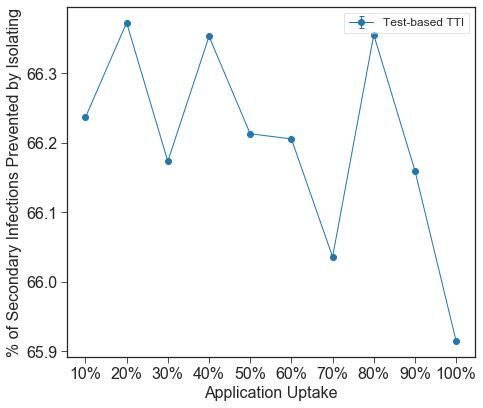

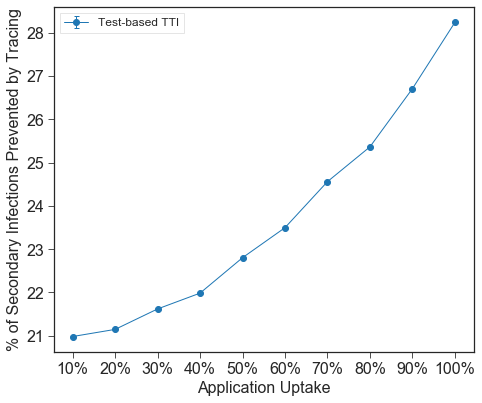

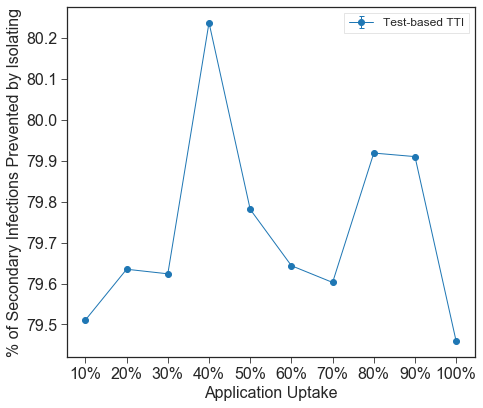

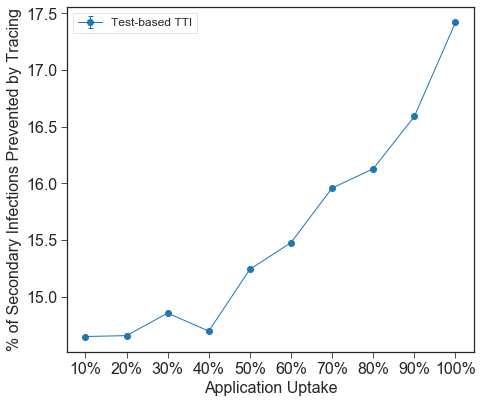

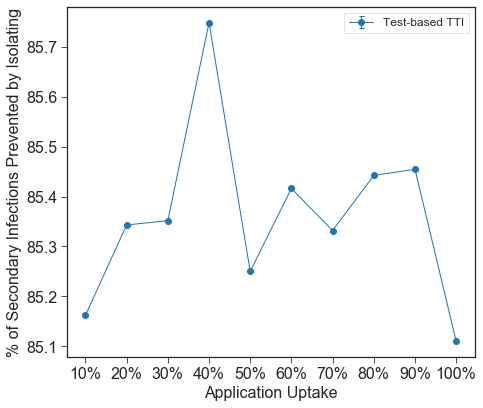

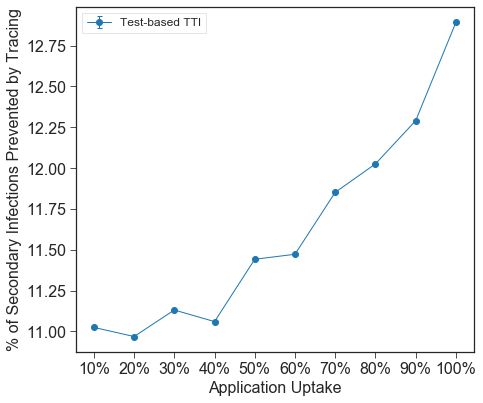

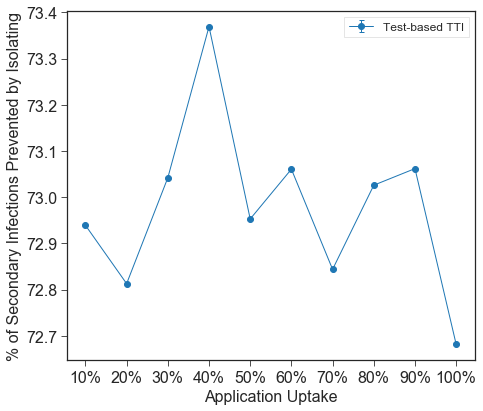

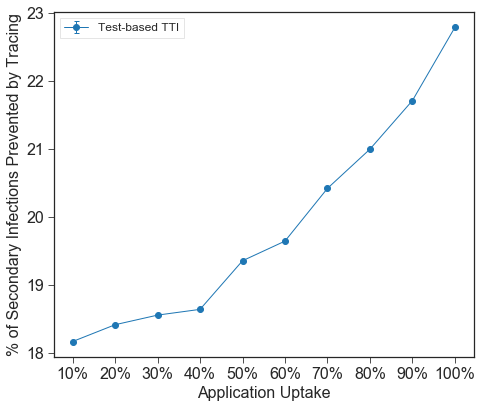

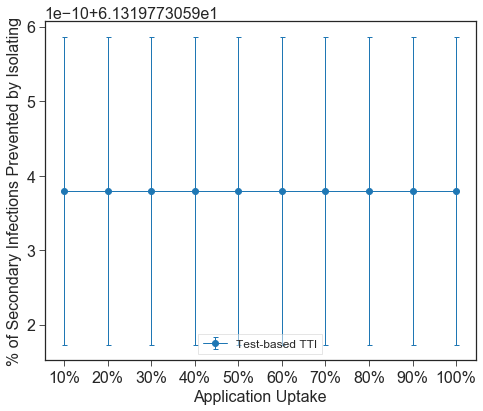

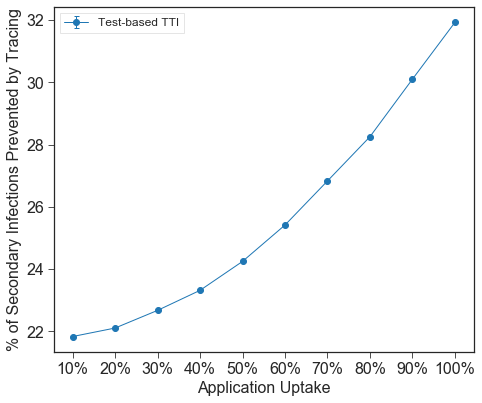

In [10]:
with plt.rc_context(rc_dct):
    for level, results in pinch_points_results.items():
        deck = utils.PdfDeck()
        for key in keys_to_plot:
            plot_lockdown(results, deck, key, order=measures_order, formatters=formatters)
            for fig in deck.figs:
                fig.tight_layout()
#                 fig.axes[0].set_title(level) ### remove this!
        deck.make(os.path.join(chart_folder, f"{level}_pinch_points.pdf"))
        individual_dir = os.path.join(os.path.join(chart_folder, f"{level}_individual"))
        os.makedirs(individual_dir, exist_ok=True)
        deck.make_individual(folder=individual_dir)

# Test Trace Tables

In [11]:
def make_tables(entry, key):
    coords, reslist = zip(*entry)
    means, stds = zip(*[(k[key]['mean'], k[key]['std']) for k in reslist])
    means_mat = pd.DataFrame(np.array(utils.sort_by(means, coords, return_idx=False)).reshape(3, 3))
    stds_mat = pd.DataFrame(np.array(utils.sort_by(stds, coords, return_idx=False)).reshape(3, 3))
    return means_mat, stds_mat


def format_table(means, stds):
    t1, t2 = ['TTI Delay (days)', 'NPI severity']

    table = means.applymap(
            lambda x: f"{x:.2f}"
        ).add(
            " \pm "
        ).add(
            stds.mul(
                1.96 # check michaels code
            ).applymap(
                lambda x: f"{x:.2f}"
            )
        ).applymap(lambda x: f"${x}$")
    new_order = [[2,2], [2,1], [1,2], [2,0], [1,1], [0,2], [1,0], [0,1], [0,0]]
    new_order = list(tuple(x) for x in new_order)
    table.index = ['No TTI'] + new_order
    table.columns = sorted(test_trace_results.keys(), reverse = True)
    table.index.name = t1
    table.columns.name = t2
    return table


def format_mean_only(means):
    t1, t2 = ['TTI Delay (days)', 'NPI severity']

    table = means.applymap(
            lambda x: f"{x:.0f}\%"
        )
    new_order = [[2,2], [2,1], [1,2], [2,0], [1,1], [0,2], [1,0], [0,1], [0,0]]
    new_order = list(tuple(x) for x in new_order)
    table.index = ['No TTI'] + new_order
    table.columns = sorted(test_trace_results.keys(), reverse = True)
    table.index.name = t1
    table.columns.name = t2
    return table
    

def make_new_tables(big_dict):
    new_order = [[2,2], [2,1], [1,2], [2,0], [1,1], [0,2], [1,0], [0,1], [0,0]]
    mean_mat = np.zeros((10, 5))
    stds_mat = np.zeros((10, 5))
    no_tti, test_based_tti = ('no_TTI', 'test_based_TTI_full_compliance')
    s_levels = sorted(test_trace_results.keys(), reverse = True)
    for s_idx, s_level in enumerate(s_levels):
        mean_mat[0, s_idx] = big_dict[s_level][no_tti]['means'].iloc[0].loc[0]
        stds_mat[0, s_idx] = big_dict[s_level][no_tti]['stds'].iloc[0].loc[0]
        for new_row_idx, (row_idx, col_idx) in enumerate(new_order):
            mean_mat[new_row_idx+1, s_idx] = big_dict[s_level][test_based_tti]['means'].iloc[row_idx].loc[col_idx]
            stds_mat[new_row_idx+1, s_idx] = big_dict[s_level][test_based_tti]['stds'].iloc[row_idx].loc[col_idx]
    mean_mat = pd.DataFrame(mean_mat, columns = s_levels)
    stds_mat = pd.DataFrame(stds_mat, columns = s_levels)
    return mean_mat, stds_mat
    

In [12]:
tt_dir = os.path.join(input_folder, "pinch-points-test-trace-delay")
test_trace_results = defaultdict(lambda: defaultdict(list))
for lockdown, target, cfg, results in resgen(tt_dir):
    if int(lockdown[1]) > 0:
        vals = [cfg[k] for k in target]
        level, measures = lockdown.split('_', maxsplit=1)
        results = results.set_index(config.STATISTIC_COLNAME, drop=True)
        test_trace_results[level][measures].append((vals, results))  

In [13]:
keys_to_plot = [
    RETURN_KEYS.stopped_by_isolation_percentage,
    RETURN_KEYS.stopped_by_tracing_percentage,
]

In [14]:
def increment_tup(tup):
    return tuple(k+1 for k in tup) if isinstance(tup, tuple) else tup

In [15]:
table_deck = utils.LatexTableDeck()

In [16]:
big_dict = defaultdict(dict)
for key in keys_to_plot:
    for k in sorted(list(test_trace_results.keys())):
        for policy, entry in test_trace_results[k].items():
            if policy in ["test_based_TTI_full_compliance", "no_TTI"]:
                means, stds = make_tables(entry, key=key)
                big_dict[k][policy] = {"means": means, "stds": stds} #turn this into dfs
    mean_mat, stds_mat = make_new_tables(big_dict)
    table_str = format_mean_only(mean_mat).rename(index=increment_tup).to_latex(escape=False)
    table_deck.add_table(
        tex_table=table_str,
        caption=nice_lockdown_name(policy) + " " + key.replace("%", "\%")
    )

In [17]:
table_deck.make(os.path.join(chart_folder, "test-trace-tables.tex"))

In [11]:
# two charts for covid and flue like
# do num tests and num contact tracings needed for infection proportions

In [29]:
# table_deck = utils.LatexTableDeck()

# for k in sorted(test_trace_results.keys()):
#     table_deck.add_section(f"Lockdown Level {k}")
#     for policy, entry in test_trace_results[k].items():
#         means, stds = make_tables(entry, key=RETURN_KEYS.reduced_r)
#         table = format_table(means, stds)
#         table_deck.add_table(
#             tex_table=table.to_latex(escape=False),
#             caption=nice_lockdown_name(policy)
#         )
#     table_deck.clearpage()
# table_deck.make("test-trace-tables.tex")

NameError: name 'charts_folder' is not defined

# Sensitivity

In [12]:
inf_props_mapping = {
     'oxteam_infection_proportions0_seed0': "vary_flu0",
     'oxteam_infection_proportions1_seed0': "vary_flu1",
     'oxteam_infection_proportions2_seed0': "vary_flu2",
     'oxteam_infection_proportions3_seed0': "vary_flu3",
     'oxteam_infection_proportions4_seed0': "vary_covid0",
     'oxteam_infection_proportions5_seed0': "vary_covid1",
     'oxteam_infection_proportions6_seed0': "vary_covid2"
}

In [27]:
def make_tables(entry, key=RETURN_KEYS.reduced_r):
    coords, reslist = zip(*entry)
    means, stds = zip(*[(k[key]['mean'], k[key]['std']) for k in reslist])
    means_mat = pd.DataFrame(np.array(utils.sort_by(means, coords, return_idx=False)).reshape(3, 3))
    stds_mat = pd.DataFrame(np.array(utils.sort_by(stds, coords, return_idx=False)).reshape(3, 3))
    return means_mat, stds_mat


def format_table(means, stds):
    t1, t2 = ['Test Delay (days)', 'Manual Trace Delay (days)']

    table = means.applymap(
            lambda x: f"{x:.2f}"
        ).add(
            " \pm "
        ).add(
            stds.mul(
                1.96 
            ).applymap(
                lambda x: f"{x:.2f}"
            )
        ).applymap(lambda x: f"${x}$")
    
    table.index =  range(1, 4)
    table.columns = range(1, 4)
    table.index.name = t1
    table.columns.name = t2
    return table

In [13]:
!ls {os.path.join(input_folder, 'case-sensitivity-quick', lockdown)}

config_10.json     config_262.json    run_115.csv        run_283.csv
config_115.json    config_283.json    run_136.csv        run_31.csv
config_136.json    config_31.json     run_157.csv        run_52.csv
config_157.json    config_52.json     run_178.csv        run_73.csv
config_178.json    config_73.json     run_199.csv        run_94.csv
config_199.json    config_94.json     run_220.csv
config_220.json    over_all_seeds.csv run_241.csv
config_241.json    run_10.csv         run_262.csv


In [14]:
case_sensitivity_results = defaultdict(dict)
case_sensitivity_dir = os.path.join(input_folder, 'case-sensitivity-quick')
for lockdown, target, cfg, results in resgen(case_sensitivity_dir):
    if lockdown[1] == '0': 
        continue
    level, measures = lockdown.split("_", maxsplit=1)
    # just load all the run_dfs and concat them...
    folder = os.path.join(case_sensitivity_dir, lockdown)
    runs = [
        pd.read_csv(
        os.path.join(folder, fname),
        index_col=0
    )
    for fname in os.listdir(folder) if fname.startswith("run") and fname.endswith(".csv")
    ]
    case_sensitivity_results[level][measures] = pd.concat(
        runs,
        axis=0
    ).drop('oxteam_infection_proportions7_seed0').rename(index=inf_props_mapping)

In [15]:
case_sensitivity_results[level][measures]

,statistic,Base R,Effective R,# Manual Traces,# App Traces,# Tests Needed,# PersonDays Quarantined,# Wasted PersonDays Quarantined
scenario,,,,,,,,
vary_flu0,mean,3.857168,1.340827,143.208800,20.678700,49.734300,2231.765200,421.411200
vary_flu0,std,0.030103,0.015205,2.714043,0.668879,0.100395,32.451370,2.563256
oxteam_p_day_noticed_symptoms9_seed0,mean,3.872157,1.365838,144.729600,19.648800,89.437200,2476.207200,653.508000
oxteam_p_day_noticed_symptoms9_seed0,std,0.040111,0.019048,3.395041,0.802068,0.165332,40.976509,3.616976
oxteam_inf_profile12_seed0,mean,3.872157,1.365838,144.729600,19.648800,89.437200,2476.207200,653.508000
oxteam_inf_profile12_seed0,std,0.040111,0.019048,3.395041,0.802068,0.165332,40.976509,3.616976
vary_flu3,mean,3.919956,1.358939,152.380800,20.176000,250.019200,3517.830400,1598.195200
vary_flu3,std,0.065761,0.029772,5.983482,1.433770,0.418291,72.271239,7.024178
vary_covid1,mean,3.872157,1.365838,144.729600,19.648800,89.437200,2476.207200,653.508000


In [16]:
import config

k_formatter = FuncFormatter(lambda x, _: f"{x:.0f}k")

class LockdownSensitivityPlotter:
    # BE: need to sort out this naming bullshit
    def __init__(self):
        self.ticklabel_maps = {
            'inf_profile': np.array([f"{int(x)}" for x in (np.array([2.11, 2.8, 3.49]) - 1)/0.69]),
             'vary_flu': np.array([f"{k}k" for k in [50, 100, 200, 300]]),
             'vary_covid': np.array([f"{k}k" for k in [10, 20, 30]]),
             'p_day_noticed_symptoms': (np.array([2, 3, 4]) - 1).astype(str),
        }
        self.xlabels = {
             'inf_profile': "Day on which primary case is most infectious",
             'vary_flu': "# COVID negative cases with COVID like symptoms (daily)",
             'vary_covid': "# COVID positive cases (daily)",
             'p_day_noticed_symptoms': (
             "Expected number of days"
             )
        }
        self.param_map = {
                 'oxteam_inf_profile11_seed0': 0,
                 'oxteam_inf_profile12_seed0': 1,
                 'oxteam_inf_profile13_seed0': 2,
                 'oxteam_p_day_noticed_symptoms10_seed0': 0,
                 'oxteam_p_day_noticed_symptoms8_seed0': 2,
                 'oxteam_p_day_noticed_symptoms9_seed0': 1,
                 'vary_flu0': 0,
                 'vary_flu1': 1,
                 'vary_flu2': 2,
                 'vary_flu3': 3,
                 'vary_covid0': 0,
                 'vary_covid1': 1,
                 'vary_covid2': 2
            }
        
        self.y_formatters = {'vary_covid': k_formatter, 'vary_flu': k_formatter}
        
    def _grouper(self, s):  ## not neat!
        for i in range(10):
            s = s.replace(f"{i}", "")
        return s.replace("oxteam_", "").replace("_seed", "")
    
    def _plot_parameter(self, ax, results_df, key):
        for measure, dfstats in results_df[[key, config.STATISTIC_COLNAME]].groupby(level=0):
            dfstats = dfstats.droplevel(0).rename(self.param_map).sort_index()
            mean = dfstats.query(
                f"{config.STATISTIC_COLNAME}=='mean'"
            ).drop(config.STATISTIC_COLNAME, axis=1).squeeze()
            std = dfstats.query(
                f"{config.STATISTIC_COLNAME}=='std'"
            ).drop(config.STATISTIC_COLNAME, axis=1).squeeze()
            xaxis = mean.index.values
            errorbar(ax, xaxis, mean.values, std.values, label=nice_lockdown_name(measure))
        return xaxis
            
    def __call__(self, results, deck, keys_to_plot):
        by_param = pd.concat(results, axis=0).groupby(level=1, by=self._grouper)
        for param_name, v in by_param:
            fig, ax = plt.subplots(1)
            xaxis = self._plot_parameter(ax, v, keys_to_plot[param_name])
            ax.set_xticks(xaxis)
            ax.set_xticklabels(self.ticklabel_maps[param_name][xaxis])
            ax.set_xlabel(self.xlabels[param_name])
            ax.set_ylabel(keys_to_plot[param_name])
            formatter = self.y_formatters.get(param_name, None)
            if formatter is not None:
                ax.yaxis.set_major_formatter(formatter)
            legend(ax)
            deck.add_figure(fig, name=param_name)
            

In [17]:
# self = plotter
# key = RETURN_KEYS.reduced_r
# by_param = pd.concat(results, axis=0).groupby(level=1, by=self._grouper)
# for param_name, results_df in by_param:
#     for measure, dfstats in results_df[[key, config.STATISTIC_COLNAME]].groupby(level=0):
#         break
#         dfstats = dfstats.droplevel(0).rename(self.param_map)
#         mean = dfstats.query(
#             f"{config.STATISTIC_COLNAME}=='mean'"
#         ).drop(config.STATISTIC_COLNAME, axis=1).squeeze()
#         std = dfstats.query(
#             f"{config.STATISTIC_COLNAME}=='std'"
#         ).drop(config.STATISTIC_COLNAME, axis=1).squeeze()
#         xaxis = mean.index.values
#         errorbar(ax, xaxis, mean.values, std.values, label=nice_lockdown_name(measure))

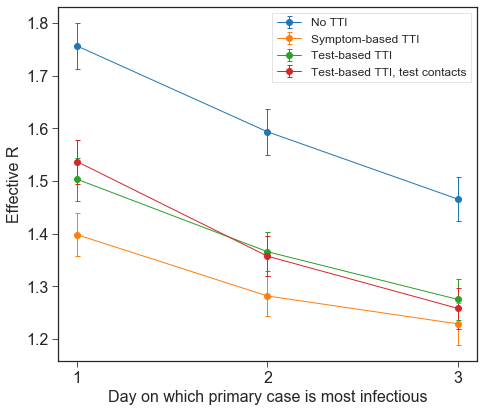

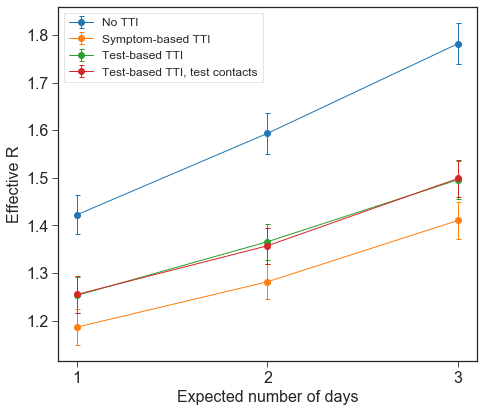

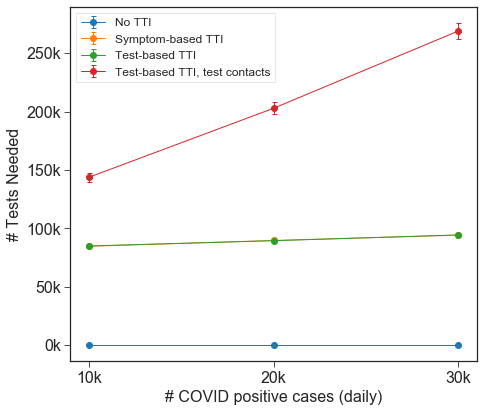

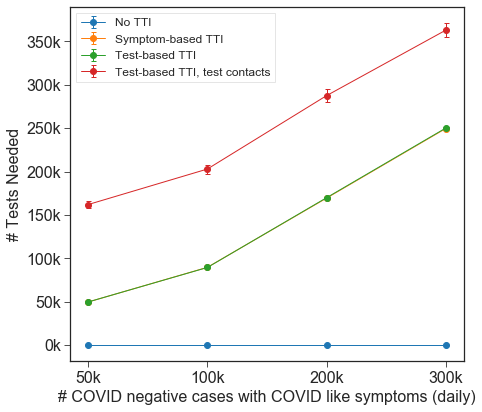

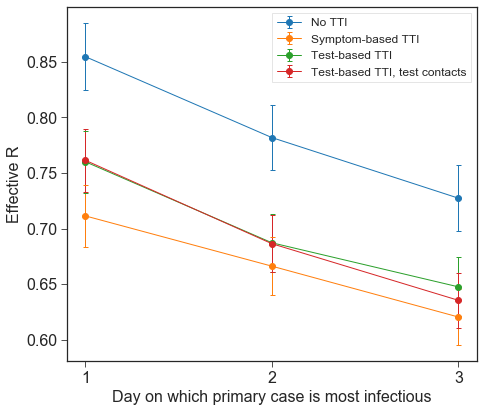

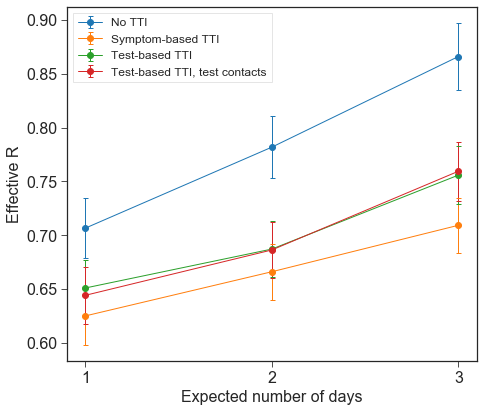

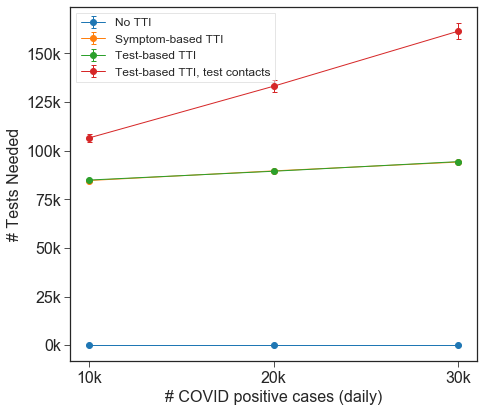

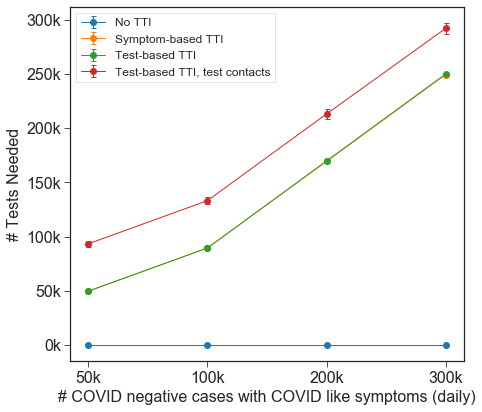

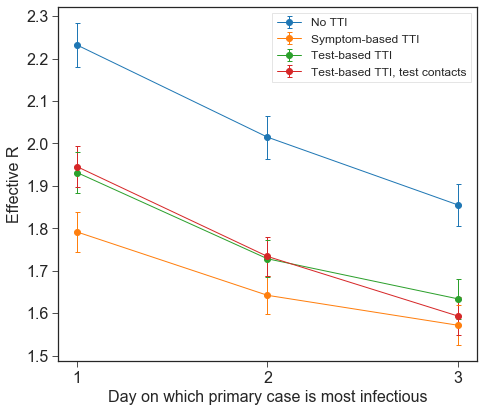

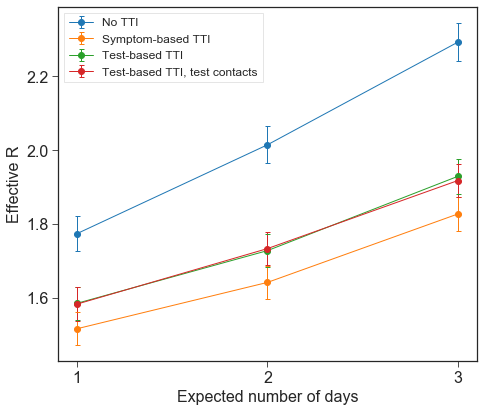

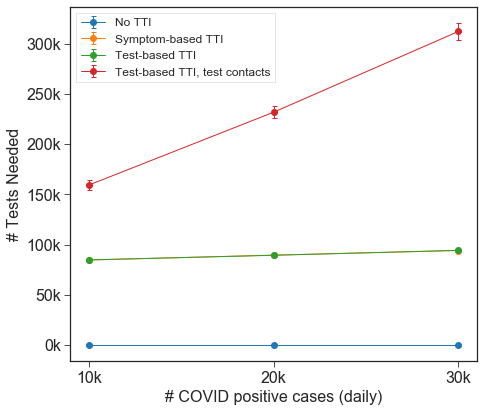

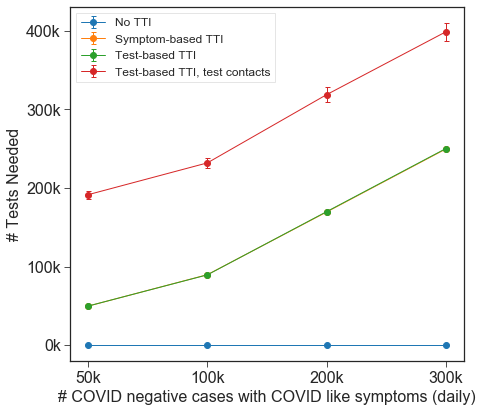

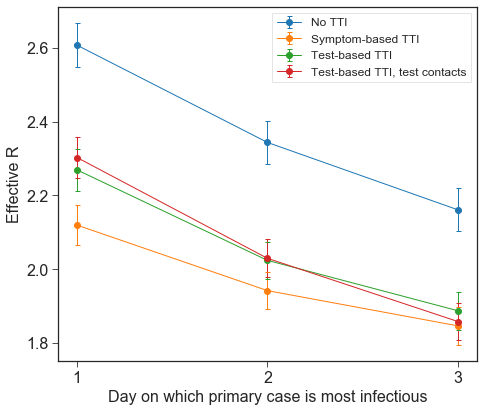

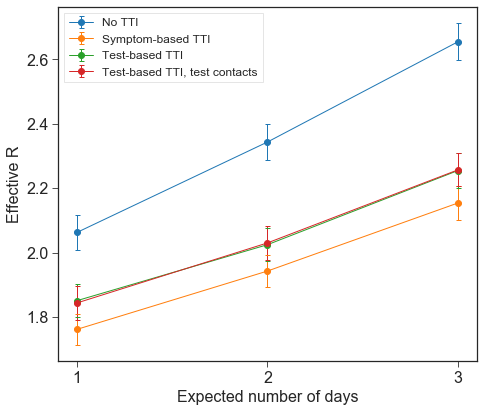

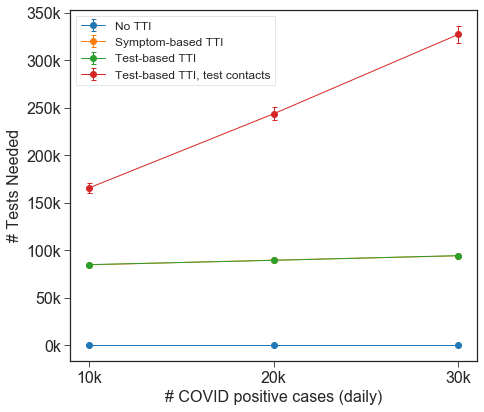

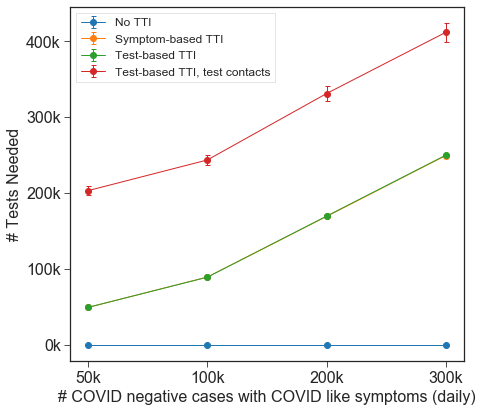

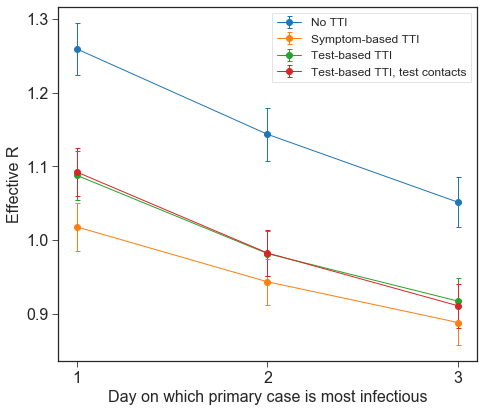

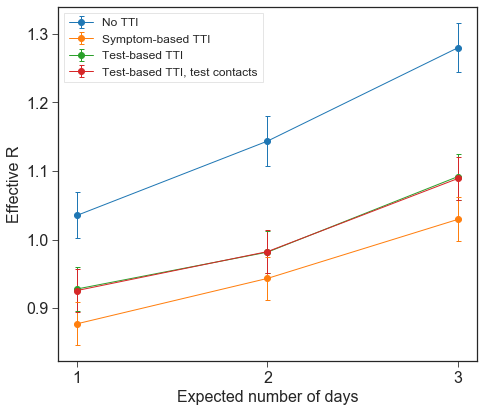

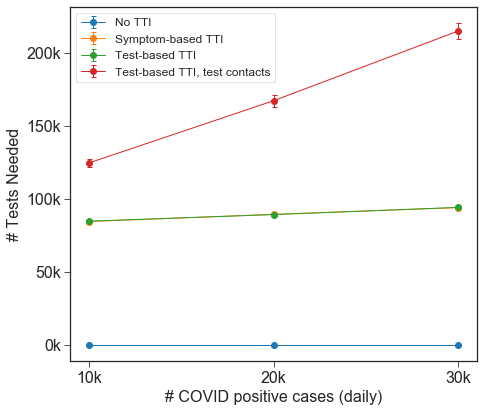

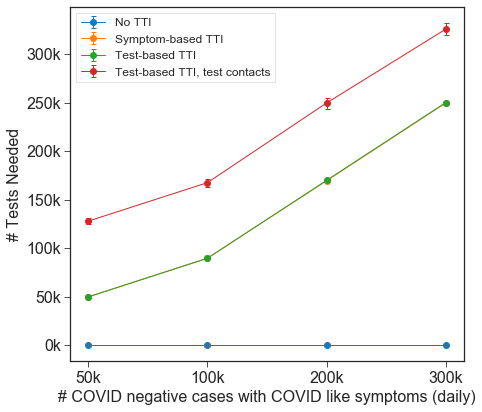

In [18]:
keys_to_plot = {
    'inf_profile': RETURN_KEYS.reduced_r,
    'p_day_noticed_symptoms': RETURN_KEYS.reduced_r,
    'vary_covid': RETURN_KEYS.tests,
    'vary_flu': RETURN_KEYS.tests
}

with plt.rc_context(rc_dct):
    plotter = LockdownSensitivityPlotter()
    for level, results in case_sensitivity_results.items():
        deck = utils.PdfDeck()
        plotter(results, deck, keys_to_plot)
        deck.make(os.path.join(chart_folder, f"{level}_sensitivity.pdf"))
        for fig in deck.figs:
            fig.tight_layout()
        individual_dir = os.path.join(os.path.join(chart_folder, f"{level}_individual"))
        os.makedirs(individual_dir, exist_ok=True)
        deck.make_individual(folder=individual_dir)